In [1]:
# Note by XO on 03/31/2022: This is an HDBSCAN clustering result analysis script. 
# The script compares any two clusters from same/different clustering space
# for overlaps, distributions in various parameters, and more...
# The focus here is to check if the clusters from the stacked sample from different
# space and zmax cut share any stellar members
# Also, for clusters from the same sample, if their metallicity distribution are consistent
# with being in the same larger group

In [2]:
# Import libraries
import glob
import numpy as np
from scipy.stats import ks_2samp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from scipy.interpolate import interpn
import seaborn as sns

cmap = ListedColormap(sns.color_palette("colorblind",60))
pal = sns.color_palette('colorblind', 60)

import astropy.coordinates as coord
import astropy.units as u

label_size = 34
matplotlib.rc('font', size=label_size) 

from collections import Counter

import warnings
warnings.filterwarnings("once")

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [3]:
# Define functions
def get_ind(space, zcut, pcut, clust_id, get_what):
    '''
    Get the index or EDR3 source id for a certain cluster
    with given clustering space, Zmax cut, and presence cut.
    '''
    
    # Confirm the space choice is valid
    if space == 'E_act':
        space_e = 'act_etot'
    elif space == 'vel_cyl':
        space_e = 'vel_cyl'
    else:
        raise ValueError('Space unrecognized. Available options are [E_act, vel_cyl]')
    
    # confirm the zmax cut choice is valid
    if not zcut in ['2500', '3000', '3500']:
        raise ValueError('Zmax cut unrecognized. Available options are [\'2500\', \'3000\', \'3500\']')
    
    # confirm the presence cut choice is valid
    if not pcut in ['0', '10', '20', '30' ,'40', '60', '80']:
        raise ValueError('Presence cut unrecognized. Available options are [\'0\', \'10\', \'20\', \'30\', \'40\', \'60\', \'80\']')
    
    # Set the read in file path
    data_dir = './' + space + '_' + zcut + '_data_20_20_err_nocut/'
    if pcut != '0':
        extratext = '_' + space + '_' + zcut + '_stacked_stars_in_clust_cut_' + pcut + '_hdbscan' + '_min_samples_20_min_clustsize_20_leaf'
    else:
        extratext = '_' + space + '_' + zcut + '_stacked_stars_in_clust_hdbscan_min_samples_20_min_clustsize_20_leaf'
    
    # Read in the id, ind, color, or anything else list from the file
    if get_what == 'id':
        clust_list = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
    elif get_what == 'ind':
        clust_list = np.load(data_dir + 'member_mask' + extratext + '.npy',allow_pickle=True)
    elif get_what == 'col':
        clust_list = np.load(data_dir + 'color' + extratext + '.npy',allow_pickle=True)
    else:
        raise ValueError('get_what unrecognized. Available options are [\'ind\', \'id\', \'col\']')
    
    # Get the clust we want
    clust_res = clust_list[clust_id]
    
    return clust_res

def get_tree(space, zcut, pcut):
    '''
    Get the merger tree for a given clustering space, Zmax cut, and presence cut.
    '''
    
    # Confirm the space choice is valid
    if space == 'E_act':
        space_e = 'act_etot'
    elif space == 'vel_cyl':
        space_e = 'vel_cyl'
    else:
        raise ValueError('Space unrecognized. Available options are [E_act, vel_cyl]')
    
    # confirm the zmax cut choice is valid
    if not zcut in ['2500', '3000', '3500']:
        raise ValueError('Zmax cut unrecognized. Available options are [\'2500\', \'3000\', \'3500\']')
    
    # confirm the presence cut choice is valid
    if not pcut in ['0', '10', '20', '30' ,'40', '60', '80']:
        raise ValueError('Presence cut unrecognized. Available options are [\'0\', \'10\', \'20\', \'30\', \'40\', \'60\', \'80\']')
    
    # Set the read in file path
    data_dir = './' + space + '_' + zcut + '_data_20_20_err_nocut/'
    if pcut != '0':
        extratext = '_' + space + '_' + zcut + '_stacked_stars_in_clust_cut_' + pcut + '_hdbscan' + '_min_samples_20_min_clustsize_20_leaf'
    else:
        extratext = '_' + space + '_' + zcut + '_stacked_stars_in_clust_hdbscan_min_samples_20_min_clustsize_20_leaf'
    
    # Read in the id or ind list from the file
    tree_df = pd.read_pickle(data_dir + 'tree' + extratext + '.pkl')
    
    return tree_df

In [4]:
# Define functions for traversing the tree and making comparisons between nodes
def find_child_node(cur_node,tree_df):
    '''
    Find the children node of the current node with the given tree data frame
    Raise error if the number of children is anything but 2
    Return the two children nodes in an array
    '''
    if cur_node not in tree_df['parent'].values:
        raise ValueError(f'Node {cur_node} has no child.')
    else:
        child_df = tree_df[tree_df['parent'] == cur_node]
        if len(child_df) != 2:
            raise ValueError(f'Unexpected number of children {len(id_tmp)} for node {cur_node}.')
        return child_df['child'].values

def check_cur_size(cur_node,tree_df,min_size=10):
    '''
    Check if the given node
    is smaller than the minimum size
    Return 'True/False
    '''
    # Find the node and compare
    if tree_df['child_size'][tree_df['child'] == cur_node].values < min_size:
        return True
    else:
        return False
    
def check_child_size(cur_node,tree_df,min_size=10):
    '''
    Check if either or both of the children node of the given node
    is smaller than the minimum size
    Return [True/False, True/False]
    '''
    # Find the cildren nodes
    children_nodes = find_child_node(cur_node,tree_df)
    left_node = children_nodes[0]
    right_node = children_nodes[1]
    
    left_flag = check_cur_size(left_node, tree_df)
    right_flag = check_cur_size(right_node, tree_df)
    
    # Output the results
    return [left_flag,right_flag]
    
def node2clust(cur_node, tree_df):
    '''
    Quick conversion from node id to leaf cluster id
    '''
#     print(f'Mapping node {cur_node} to cluster id...')
    arr_child = tree_df['child'].values
    arr_parent = tree_df['parent'].values
    arr_leaf = arr_child[[(each not in arr_parent) for each in arr_child]]
    
    return np.where(arr_leaf == cur_node)[0][0]
    
    
def compare(left_node, right_node, node_dict, tree_df, compare_which):
    '''
    Compare the two nodes given to see if they can be merged
    return True/False
    '''
    # Extract the relevant star index for comparison
    left_ind = node_dict[left_node][3]
    right_ind = node_dict[right_node][3]
    
    # Do the comparison
    if compare_which == 'feh':
        feh1 = df_vel_all.loc[left_ind,'m_h_mean'].values
        feh2 = df_vel_all.loc[right_ind,'m_h_mean'].values

        feh1_nonan = feh1[np.isnan(feh1) == False]
        feh2_nonan = feh2[np.isnan(feh2) == False]

        # Check if there's no measirement for Fe/H
        if (False not in np.isnan(feh1)):
            print(f'Node {left_node} has no [Fe/H] measurement. Automatically merged.')
            return True
        if (False not in np.isnan(feh2)):
            print(f'Node {right_node} has no [Fe/H] measurement. Automatically merged.')
            return True

        # KS test?
        # pval = ks_2samp(feh1,feh2)[1]
        pval = ks_2samp(feh1_nonan,feh2_nonan)[1]
    elif compare_which == 'ecc':
        ecc1 = df_orb_all.loc[left_ind,'ecc'].values
        ecc2 = df_orb_all.loc[right_ind,'ecc'].values

        ecc1_nonan = ecc1[np.isnan(ecc1) == False]
        ecc2_nonan = ecc2[np.isnan(ecc2) == False]

        # Check if there's no measirement for ecc
        if (False not in np.isnan(ecc1)):
            print(f'Node {left_node} has no ecc measurement. Automatically merged.')
            return True
        if (False not in np.isnan(ecc2)):
            print(f'Node {right_node} has no ecc measurement. Automatically merged.')
            return True

        # KS test?
        # pval = ks_2samp(ecc1,ecc2)[1]
        pval = ks_2samp(ecc1_nonan,ecc2_nonan)[1]
    
    else:
        raise ValueError(f'Input compare_which: {compare_which} unrecognized.')
    
    return pval > 0.05

def traverse(cur_node,node_dict,tree_df,comp_space,cur_layer,par_node,compare_which):
    '''
    A recursion function for traversing any given merger tree 
    and decide whether each node can be merged or not
    '''
    # Base condition: Check if we've reached the leaf of the tree
    # If it's the leaf, extract the index of the stars in the leaf cluster
    if cur_node not in tree_df['parent'].values:
        # Get the clust id
        clust_leaf = node2clust(cur_node, tree_df)
        clust_leaf_ind = get_ind(comp_space[0], comp_space[1], comp_space[2], clust_leaf, 'ind')
        node_dict[cur_node] = (True, 'Already a leaf node',cur_layer,clust_leaf_ind,par_node)
        return
    
    # Traverse down the children
    children_nodes = find_child_node(cur_node,tree_df)
    left_node = children_nodes[0]
    right_node = children_nodes[1]
    traverse(left_node,node_dict,tree_df,comp_space,cur_layer+1,cur_node,compare_which)
    traverse(right_node,node_dict,tree_df,comp_space,cur_layer+1,cur_node,compare_which)
    
    # Decide if the nodes can be merged for the current node
    if not (node_dict[left_node][0] and node_dict[right_node][0]):
        node_dict[cur_node] = (False, 'Children cannot merge.',cur_layer,[],par_node)
    elif True in check_child_size(cur_node,tree_df):
        clust_merge_ind = np.concatenate((node_dict[left_node][3],node_dict[right_node][3]))
        if check_child_size(cur_node,tree_df) == [True, True]:
            node_dict[cur_node] = (True, f'Children {left_node} and {right_node} too small and merged.',cur_layer,\
                                   clust_merge_ind,par_node)
        elif check_child_size(cur_node,tree_df) == [True, False]:
            node_dict[cur_node] = (True, f'Left child {left_node} too small and merged.',cur_layer,\
                                   clust_merge_ind,par_node)
        elif check_child_size(cur_node,tree_df) == [False, True]:
            node_dict[cur_node] = (True, f'Right child {right_node} too small and merged.',cur_layer,\
                                   clust_merge_ind,par_node)
    elif compare(left_node, right_node, node_dict, tree_df,compare_which):
        clust_merge_ind = np.concatenate((node_dict[left_node][3],node_dict[right_node][3]))
        node_dict[cur_node] = (True, 'Passed comparison and merged.',cur_layer,clust_merge_ind,par_node)
    else:
        node_dict[cur_node] = (False, 'Failed comparison and not merged.',cur_layer,[],par_node)

In [5]:
# Define a plotting funciton for plotting specific lists of stars in all relevant spaces
def plot_summary_v3(df_vel,df_orb,ind_list,c_list,title,legends,list_mask=False,filename=None,bg=False,ds=True,noise=True,ind_add_cut=[]):
    if len(ind_add_cut) == 0 and list_mask == True:
        ind_add_cut = ind_cut
    
    f = plt.figure(figsize=[30,40])
    
#     plt.suptitle(title)
    
    # Set the plotting parameters
    plt.subplot(4,3,1)
    plt.xlim([-4.5e3,4.5e3])
    plt.ylim([-1.7e5,0.1e5])
    plt.xlabel(r'$L_z$ [kpc km s$^{-1}$]')
    plt.ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')
    
    # Make a fake dot for the legend
    # Adjusted the auto-legend setting to always make stars for clusters and dots for noises
    for i in range(len(ind_list)):
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:  
            mkr='*'
            ec='k'
        else:
            mkr='.'
            ec=c_list[i][0]
        try:
            # Check if needs downsampling; if so, flag it in legend
            if len(ind_list[i]) > 5000 and ds == True:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i]+'_sp',marker=mkr,edgecolors=ec)
            else:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i],marker=mkr,edgecolors=ec)
        except IndexError:
            print("Cluster number:",legends[i],'has zero stars.')
#     plt.legend(fontsize='small')
    
    plt.subplot(4,3,2)
    plt.xlim([3000,13000])
    plt.ylim([-5000,5000])
    plt.xlabel(r'$r_{gal}$ [pc]')
    plt.ylabel('Z [pc]')
    
    plt.subplot(4,3,3)
    plt.xlim([0,16])
    plt.ylim([0,26])
    plt.xlabel(r'$r_{peri}$ [kpc]')
    plt.ylabel(r'$r_{apo}$ [kpc]')
    
    plt.subplot(4,3,4)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{\phi}$ [km/s]')
    
    plt.subplot(4,3,5)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{z}$ [km/s]')
    
    plt.subplot(4,3,6)
    plt.xlim([0,1])
    plt.xlabel(r'Ecc [Unitless]')
    plt.ylabel(r'$f$(Ecc)')
    
    plt.subplot(4,3,7)
    plt.xlim([0,1])
    plt.ylim([1000,5000])
    plt.xlabel('Ecc [unitless]')
    plt.ylabel('Zmax [pc]')
    
    plt.subplot(4,3,8)
    plt.xlabel(r'$J_{\phi}/J_{tot}$ [kpc km/s]')
    plt.ylabel(r'$(J_z-J_R)/J_{tot}$ [kpc km/s]')
    
    plt.subplot(4,3,9)
    plt.xlim([-3.1,1.0])
    plt.ylim([-0.21,0.61])
    plt.xlabel('[Fe/H] [dex]')
    plt.ylabel(r'[$\alpha$/Fe] [dex]')
    
    plt.subplot(4,3,10)
    plt.xlim([0, 2500])
    plt.ylim([-3800, 3800])
    plt.xlabel(r'$J_R$ [kpc km/s]')
    plt.ylabel(r'$J_{\phi}$ [kpc km/s]')
    
    plt.subplot(4,3,11)
    plt.xlim([0, 2500])
    plt.ylim([0, 2000])
    plt.xlabel(r'$J_R$ [kpc km/s]')
    plt.ylabel(r'$J_z$ [kpc km/s]')
    
    plt.subplot(4,3,12)
    plt.xlim([-3.1,1.0])
    plt.xlabel(r'[Fe/H] [dex]')
    plt.ylabel(r'$f$([Fe/H])')
    
    for i in range(len(ind_list)):
        if list_mask == True:
            ind = ind_add_cut[ind_list[i]]
        else:
            ind = ind_list[i]
        color = c_list[i]
        
            
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ms=50
            al=1 
#             ec=['k']*len(ind)
            ec='none'
            zord=i
        else:
            mkr='.'
            ms=20
            al=0.3
            ec='none'
            zord=-1
        
        # Determine if there are more than 10000 data points, if so, down-sample it
        if len(ind) > 5000 and ds == True:
            ii = np.random.choice(len(ind),int(len(ind)/20),replace=False)
            ind = ind[ii]
            
            # Check to see if color list also needs to be downsampled
            if len(color) > len(ind): 
                color = color[ii]
        
        # Plot E vs. Lz
        plt.subplot(4,3,1)
        plt.scatter(df_orb.loc[ind,'Lz'],df_orb.loc[ind,'Etot'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        # Plot Z vs. r_gal
        plt.subplot(4,3,2)
        plt.scatter(np.sqrt(df_vel.loc[ind,'XGC']**2+df_vel.loc[ind,'YGC']**2),df_vel.loc[ind,'ZGC'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        # Plot apo vs. peri
        plt.subplot(4,3,3)
        plt.scatter(df_orb.loc[ind,'peri']/1000,df_orb.loc[ind,'apo']/1000,s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vphi vs. vr
        plt.subplot(4,3,4)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vphi_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vz vs. vr
        plt.subplot(4,3,5)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vz_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot 1d Ecc histogram: skip the noise
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)):
            plt.subplot(4,3,6)
#             plt.hist(df_orb.loc[ind,'ecc'],histtype='step',bins=np.arange(0.0,1.05,0.05),color=color[0])
            sns.distplot(df_orb.loc[ind,'ecc'],hist=False,kde=True,bins=np.arange(0.0,1.05,0.05),kde_kws={"color": color[0]})
            # Have to set the x-axis again to overwrite sns auto axis
            plt.xlabel(r'Ecc [Unitless]')
        
        
        # Plot zmax vs. ecc
        plt.subplot(4,3,7)
        plt.scatter(df_orb.loc[ind,'ecc'],df_orb.loc[ind,'zmax'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
    
        # Plot Action diamond
        plt.subplot(4,3,8)
        plt.scatter(df_orb.loc[ind,'diamond_x'],df_orb.loc[ind,'diamond_y'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Alpha vs. [Fe/H]
        plt.subplot(4,3,9)
        plt.scatter(df_vel.loc[ind,'m_h_ap17'],df_vel.loc[ind,'alpha_m_ap17'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Jphi vs. JR
        plt.subplot(4,3,10)
        plt.scatter(df_orb.loc[ind,'JR'],df_orb.loc[ind,'Jphi'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Jz vs. JR
        plt.subplot(4,3,11)
        plt.scatter(df_orb.loc[ind,'JR'],df_orb.loc[ind,'Jz'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot 1d [Fe/H] histogram; skip the noise
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)):
            plt.subplot(4,3,12)
#             plt.hist(df_vel.loc[ind,'m_h_mean'],histtype='step',bins=np.arange(-3.1,1.1,0.1),color=color[0])
            sns.distplot(df_vel.loc[ind,'m_h_mean'],hist=False,kde=True,bins=np.arange(-3.1,1.1,0.1),kde_kws={"color": color[0]})
            plt.xlabel(r'[Fe/H] [dex]')
        
    
    f.tight_layout()
    plt.show()
    if filename != None:
        f.savefig(filename,layout='tight')

In [6]:
# Import the data
df_vel_all = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')
df_orb_all = pd.read_hdf('../data/dr3_orb_param_err_g2_only.h5')

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject
/opt/anaconda3/envs/pandas_project/lib/python3.8/site-packages/tables/__init__.py:24: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/opt/anaconda3/envs/pandas_project/lib/python3.8/site-packages/tables/req_versions.py:20: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  min_numpy_version = LooseVersion('1.9.3')
/opt/anaconda3/envs/pandas_project/lib/python3.8/site-packages/tables/filters.py:27: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  blosc_version = LooseVersion(tables.which_lib_version("blosc")[1])
/opt/anaconda3/envs/pandas_project/lib/python3.8/site-packages/tables/tests/common.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.v

In [7]:
# Set all -9999 values in APOGEE DR17 [Fe/H] and alpha to np.nan for easier calculation later
ind_ap17_999 = np.where(df_vel_all.loc[:,'m_h_ap17'] < -100)[0]
df_vel_all.loc[ind_ap17_999,'m_h_ap17'] = np.nan


ind_ap17_999 = np.where(df_vel_all.loc[:,'m_h_err_ap17'] < -100)[0]
df_vel_all.loc[ind_ap17_999,'m_h_err_ap17'] = np.nan


ind_ap17_999 = np.where(df_vel_all.loc[:,'alpha_m_ap17'] < -100)[0]
df_vel_all.loc[ind_ap17_999,'alpha_m_ap17'] = np.nan

ind_ap17_999 = np.where(df_vel_all.loc[:,'alpha_m_err_ap17'] < -100)[0]
df_vel_all.loc[ind_ap17_999,'alpha_m_err_ap17'] = np.nan

In [8]:
df_vel_all.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2', 'vr_g2', 'vphi_g2',
       'vz_g2', 'vrerr_g2', 'vphierr_g2', 'vzerr_g2', 'vrphicov_g2',
       'vrzcov_g2', 'vphizcov_g2', 'm_h_ap17', 'm_h_err_ap17', 'alpha_m_ap17',
       'alpha_m_err_ap17', 'aspcap_flg_ap17'],
    

In [9]:
# calculate the columns for the scaled action diamond
df_orb_all['Jtot'] = np.sqrt(df_orb_all['Jphi']**2+df_orb_all['JR']**2+df_orb_all['Jz']**2)
df_orb_all['diamond_x']=df_orb_all['Jphi']/df_orb_all['Jtot']
df_orb_all['diamond_y']=(df_orb_all['Jz']-df_orb_all['JR'])/df_orb_all['Jtot']

# Calculate the error for Jtot and diamond_x/y
df_orb_all['e_Jtot'] = np.sqrt(df_orb_all['Jphi']**2*df_orb_all['e_Jphi']**2+df_orb_all['JR']**2*df_orb_all['e_JR']**2+df_orb_all['Jz']**2*df_orb_all['e_Jz']**2)/df_orb_all['Jtot']
df_orb_all['e_diamond_x']=np.sqrt(df_orb_all['Jtot']**2*df_orb_all['e_Jphi']**2+df_orb_all['e_Jtot']**2*df_orb_all['Jphi']**2)/df_orb_all['Jtot']**2
df_orb_all['e_diamond_y']=np.sqrt(df_orb_all['Jtot']**2*(df_orb_all['e_JR']**2+df_orb_all['e_Jz']**2)+df_orb_all['e_Jtot']**2*(df_orb_all['Jz']-df_orb_all['JR'])**2)/df_orb_all['Jtot']**2

# Calculate L_perp for clustering
df_orb_all['Lperp'] = np.sqrt(df_orb_all['Lx']**2+df_orb_all['Ly']**2)
df_orb_all['e_Lperp'] = np.sqrt(df_orb_all['Lx']**2*df_orb_all['e_Lx']**2+df_orb_all['Ly']**2*df_orb_all['e_Ly']**2)/df_orb_all['Lperp']

# Set the default metallicity to the APOGEE DR7 values
# df_vel_all['m_h_mean'], df_vel_all['e_m_h_mean'] = df_vel_all['m_h_ap17'], df_vel_all['m_h_err_ap17']

# Set the default metallicity to the LAMOST DR6 STELLAR values
df_vel_all['m_h_mean'], df_vel_all['e_m_h_mean'] = df_vel_all['m_h_l6s'], df_vel_all['m_h_err_l6s']


In [10]:
# get the tree
# comp_space in format: ['vel_cyl'/'E_act','2500'/'3000'/'3500','0'/'10'/'20'/'30'/'40'/'60'/'80']
comp_space = ['vel_cyl','2500','20']
tree_df_all = get_tree(comp_space[0],comp_space[1],comp_space[2])

# Isolate out the non noise part
tree_df = tree_df_all[tree_df_all['child_size'] > 1]
print(tree_df.head())

    parent  child  lambda_val  child_size
0     1906   1907    0.332460          63
1     1906   1908    0.332460        1843
25    1908   1909    1.004613          39
26    1908   1910    1.004613        1793
41    1910   1911    1.028934        1622


In [40]:
# Initiate the node_dict
node_dict = {}

traverse(1884, node_dict, tree_df, comp_space,0,None,'feh')

In [42]:
for node in tree_df['child']:
    if node_dict[node][0] == False:
        print(node,node_dict[node])
    

1886 (False, 'Children cannot merge.', 1, [], 1884)
1888 (False, 'Children cannot merge.', 2, [], 1886)
1889 (False, 'Failed comparison and not merged.', 3, [], 1888)
1890 (False, 'Children cannot merge.', 3, [], 1888)
1892 (False, 'Children cannot merge.', 4, [], 1890)
1893 (False, 'Children cannot merge.', 5, [], 1892)
1894 (False, 'Children cannot merge.', 5, [], 1892)
1896 (False, 'Children cannot merge.', 6, [], 1893)
1898 (False, 'Failed comparison and not merged.', 7, [], 1896)
1904 (False, 'Children cannot merge.', 6, [], 1894)
1910 (False, 'Children cannot merge.', 7, [], 1904)
1922 (False, 'Children cannot merge.', 8, [], 1910)
1926 (False, 'Failed comparison and not merged.', 9, [], 1922)


In [43]:
for node in tree_df['child']:
    if node_dict[node][0] == True:
        print(node,node_dict[node][1])

1885 Already a leaf node
1887 Already a leaf node
1891 Passed comparison and merged.
1895 Already a leaf node
1897 Already a leaf node
1899 Already a leaf node
1900 Passed comparison and merged.
1901 Already a leaf node
1902 Already a leaf node
1903 Already a leaf node
1905 Already a leaf node
1906 Already a leaf node
1907 Passed comparison and merged.
1908 Already a leaf node
1909 Passed comparison and merged.
1911 Passed comparison and merged.
1912 Passed comparison and merged.
1913 Already a leaf node
1914 Already a leaf node
1915 Passed comparison and merged.
1916 Passed comparison and merged.
1917 Already a leaf node
1918 Already a leaf node
1919 Already a leaf node
1920 Already a leaf node
1921 Already a leaf node
1923 Already a leaf node
1924 Already a leaf node
1925 Already a leaf node
1927 Passed comparison and merged.
1928 Already a leaf node
1929 Already a leaf node
1930 Already a leaf node


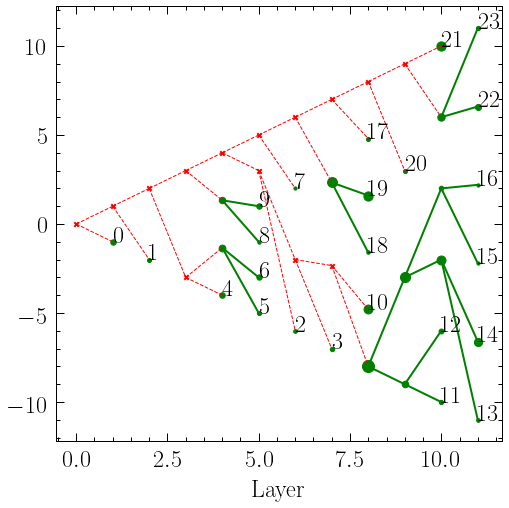

In [47]:
f = plot_tree(tree_df, node_dict, node_scale=0.5)
f.savefig('node_merging/node_merging_'+comp_space[0]+'_zcut_'+comp_space[1]+'_pcut_'+comp_space[2]+'_ecc_test.pdf')

In [46]:
# Visualize the node dictionary
def plot_tree(tree_df, node_dict, node_scale=1):
    f = plt.figure(figsize=[8,8])
    
    # Go through the tree and figure out how many nodes are in each layer based on node_dict
    layer_list = []
    for node in tree_df['child'].values:
        layer = node_dict[node][2]
        layer_list.append(layer)
    layer_count = Counter(layer_list)
    
    # Create a temp dict for recording the y-position of the nodes
    ypos_dict = {}
    
    # Plot the nodes from root to leaf
    for layer in range(np.max(layer_list)+1):
        layer_mask = [node_dict[node][2] == layer for node in list(node_dict.keys())]
        layer_node = np.arange(len(list(node_dict.keys())))[layer_mask]
        N_node = len(layer_node)
        
        # Calculate spacing between nodes
        scale = 2*layer
        y_pos = np.linspace(-layer, layer, N_node)
        
        
        for i in range(N_node):
            node_ii = layer_node[i]
            cur_node = list(node_dict.keys())[node_ii]
            
            # Record the y-positions
            ypos_dict[cur_node] = y_pos[i]
            
            # Determine the node plotting style
            if node_dict[cur_node][0] == False:
                size = 20
                marker = 'x'
                color = 'r'
            elif node_dict[cur_node][0] == True:
                size = len(node_dict[cur_node][3])*node_scale
                marker = 'o'
                color = 'g'
                
            # Draw the node
            plt.scatter(layer, y_pos[i], s=size, marker=marker, color=color)
            
            # Label the node if it's a leaf node
            if cur_node not in tree_df['parent'].values:
                clust_leaf = node2clust(cur_node, tree_df)
                plt.annotate(str(clust_leaf),(layer, y_pos[i]))
            
            # Determine if the parent node is mergeable or if there's a parent node
            if node_dict[cur_node][4] == None:
                continue 
            elif node_dict[node_dict[cur_node][4]][0] == True:
                linestyle = '-'
                linewidth = 2
                linecolor = 'g'
            else:
                linestyle = '--'
                linewidth = 1
                linecolor = 'r'
            # Draw the line toward the parent nodes
            plt.plot([layer-1, layer],[ypos_dict[node_dict[cur_node][4]],ypos_dict[cur_node]],ls=linestyle,lw=linewidth,color=linecolor)
    
    plt.xlabel('Layer')
    plt.show()
    return f

In [311]:
clust1_ind = get_ind('vel_cyl','2500','0',0,'ind')
clust2_ind = get_ind('vel_cyl','2500','0',1,'ind')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

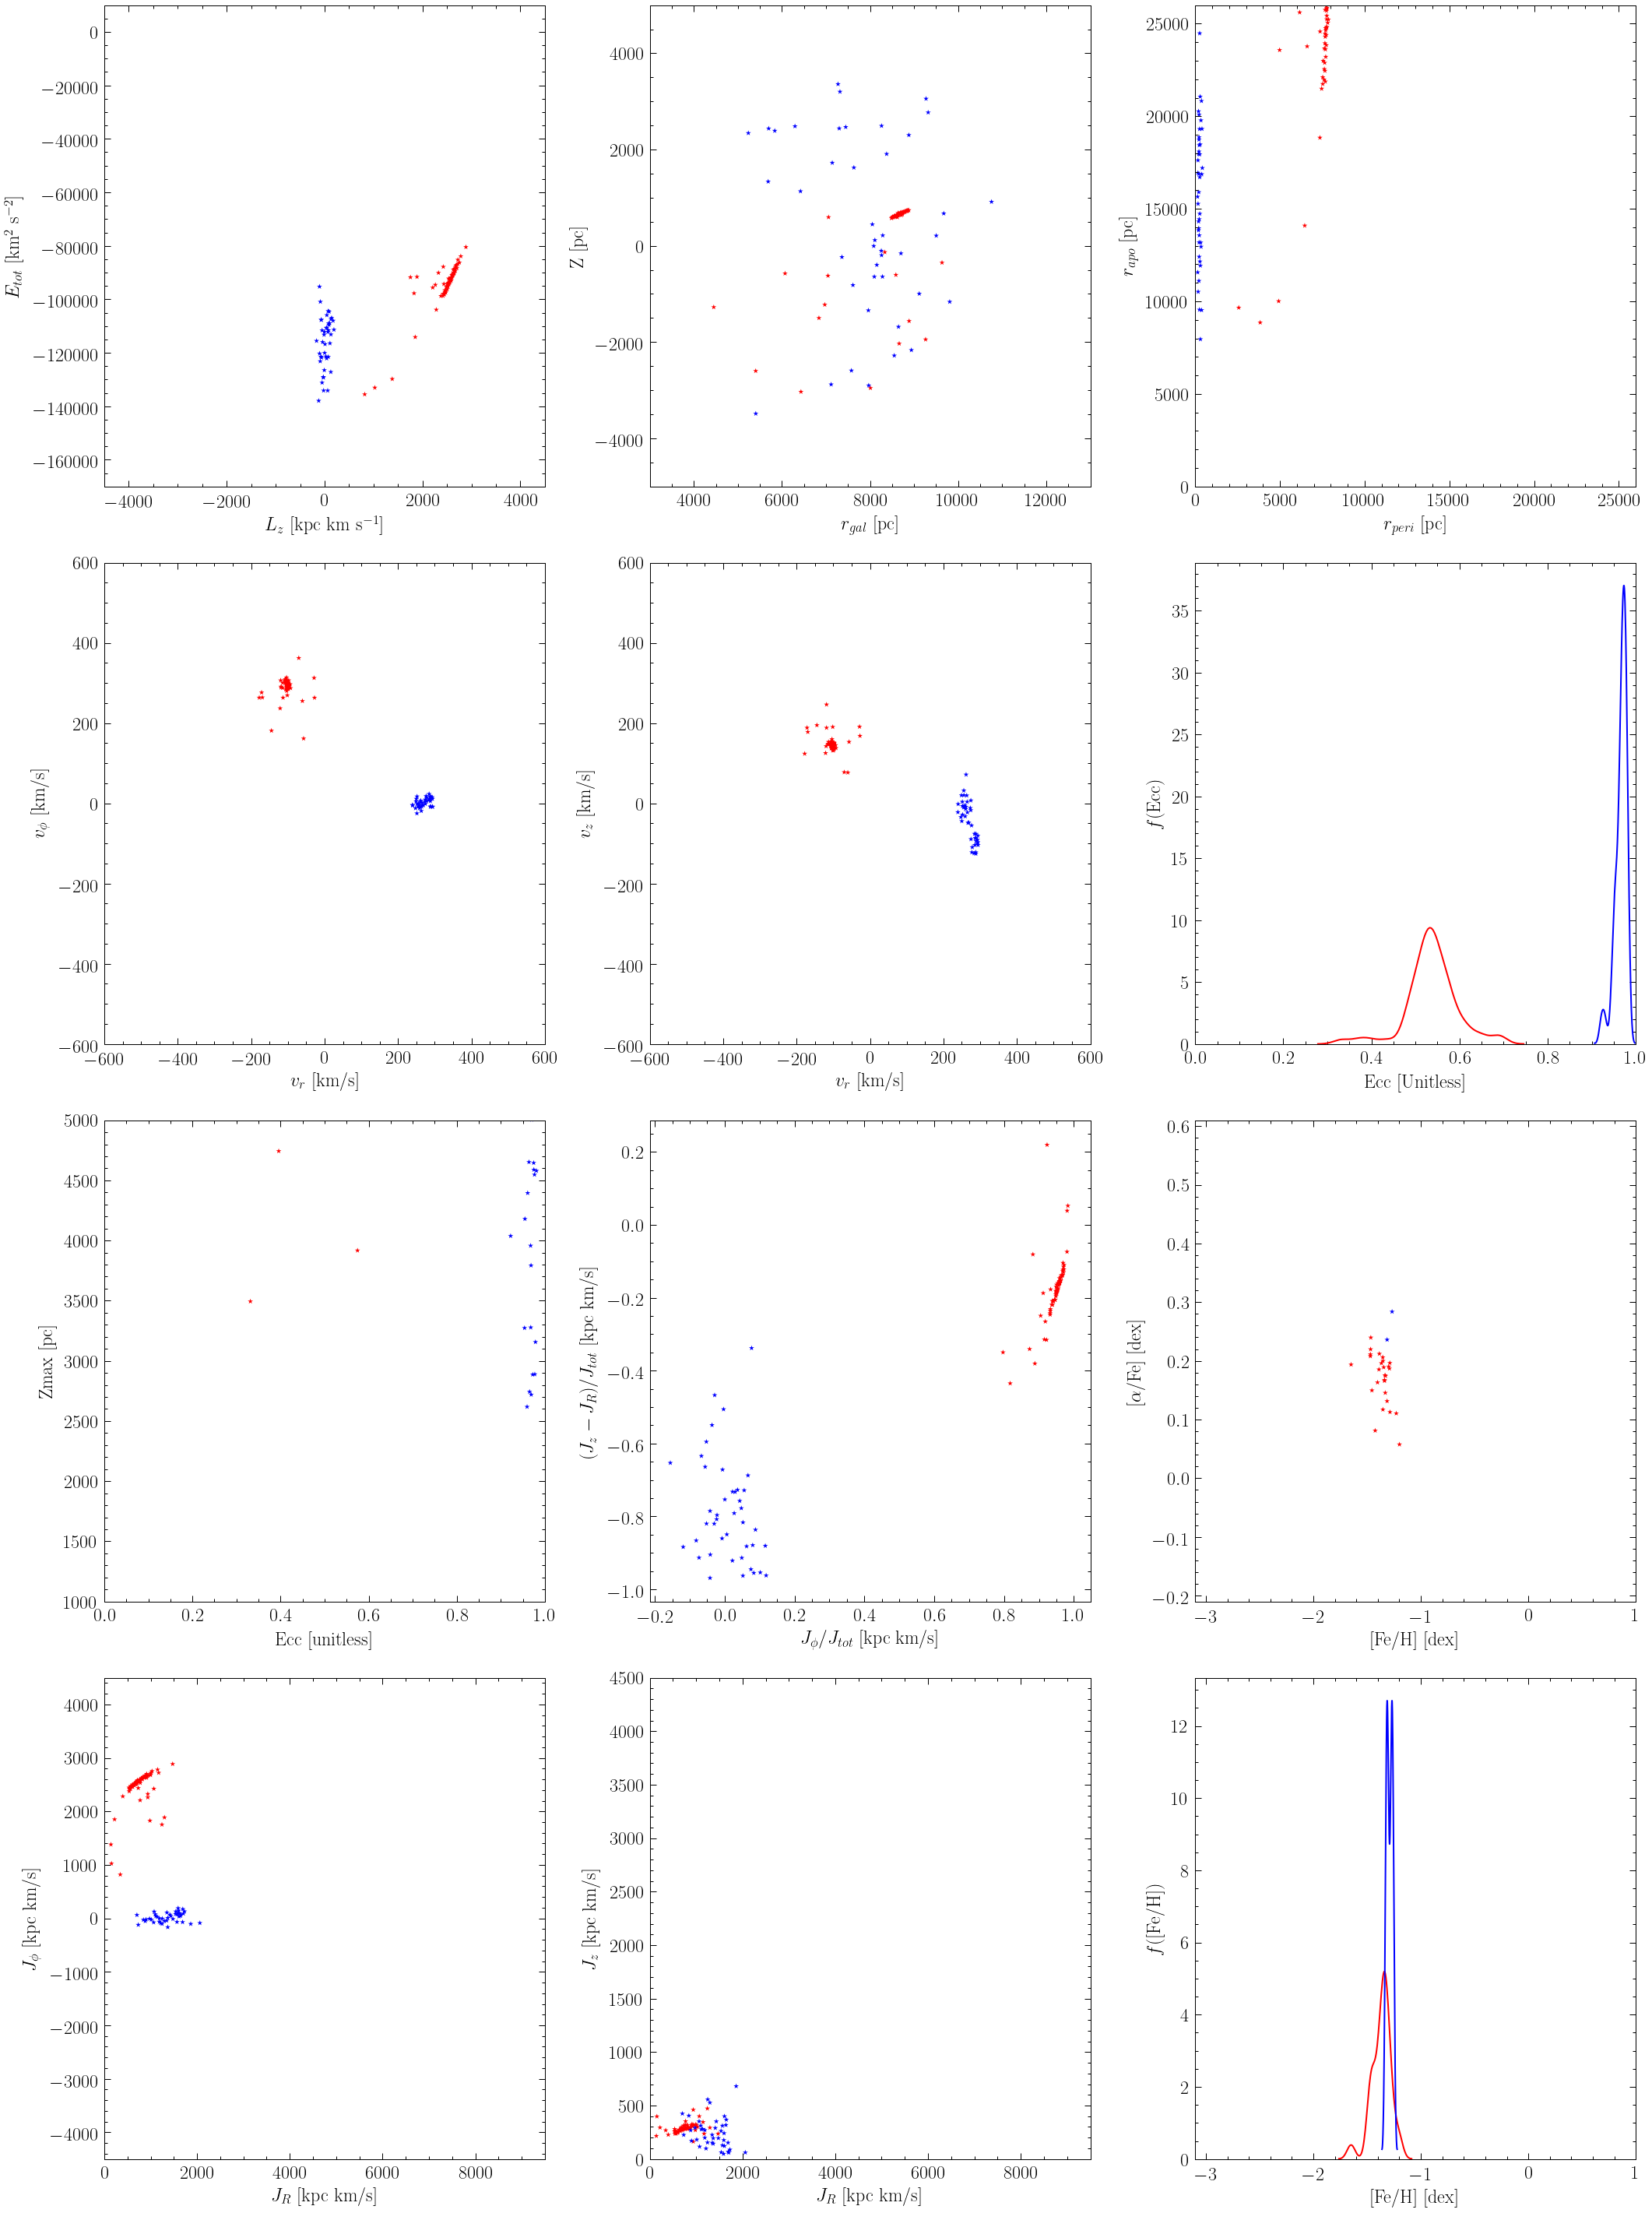

In [312]:
# Quick plot and check if the index are correctly extracted
plot_summary_v3(df_vel_all,df_orb_all,ind_list=[clust1_ind,clust2_ind],c_list=[['r'],['b']],
                title='',legends=['',''],list_mask=False,ind_add_cut=[],ds=False,noise=False,
                filename=None)

In [24]:
# Reproduce the summary plots
clust_space = ['E_act','2500','0']
clust_all_ind = []
clust_all_col = []

tree_df_all = get_tree(clust_space[0],clust_space[1],clust_space[2])
# Isolate out the non noise part
tree_df = tree_df_all[tree_df_all['child_size'] > 1]
# Count the # of leaf clusters by doing (unique # of child - unique # of parent + 1)
N_clust = len(np.unique(tree_df['child']))-len(np.unique(tree_df['parent']))+1
print(N_clust)


for i in range(N_clust):
    ind_tmp = get_ind(clust_space[0],clust_space[1],clust_space[2],i,'ind')
    col_tmp = get_ind(clust_space[0],clust_space[1],clust_space[2],i,'col')
    clust_all_ind.append(ind_tmp.copy())
    clust_all_col.append(np.array(list(col_tmp.copy())*len(ind_tmp)).reshape((len(ind_tmp),4)))

23


/var/folders/gf/j4j20wvx1d77qj5hx1gjrwf40000gn/T/ipykernel_93674/1316449873.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,3,1)
/var/folders/gf/j4j20wvx1d77qj5hx1gjrwf40000gn/T/ipykernel_93674/1316449873.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,3,2)
/var/folders/gf/j4j20wvx1d77qj5hx1gjrwf40000gn/T/ipykernel_93674/1316449873.py:138: MatplotlibDeprecationWarning: Adding an axes using

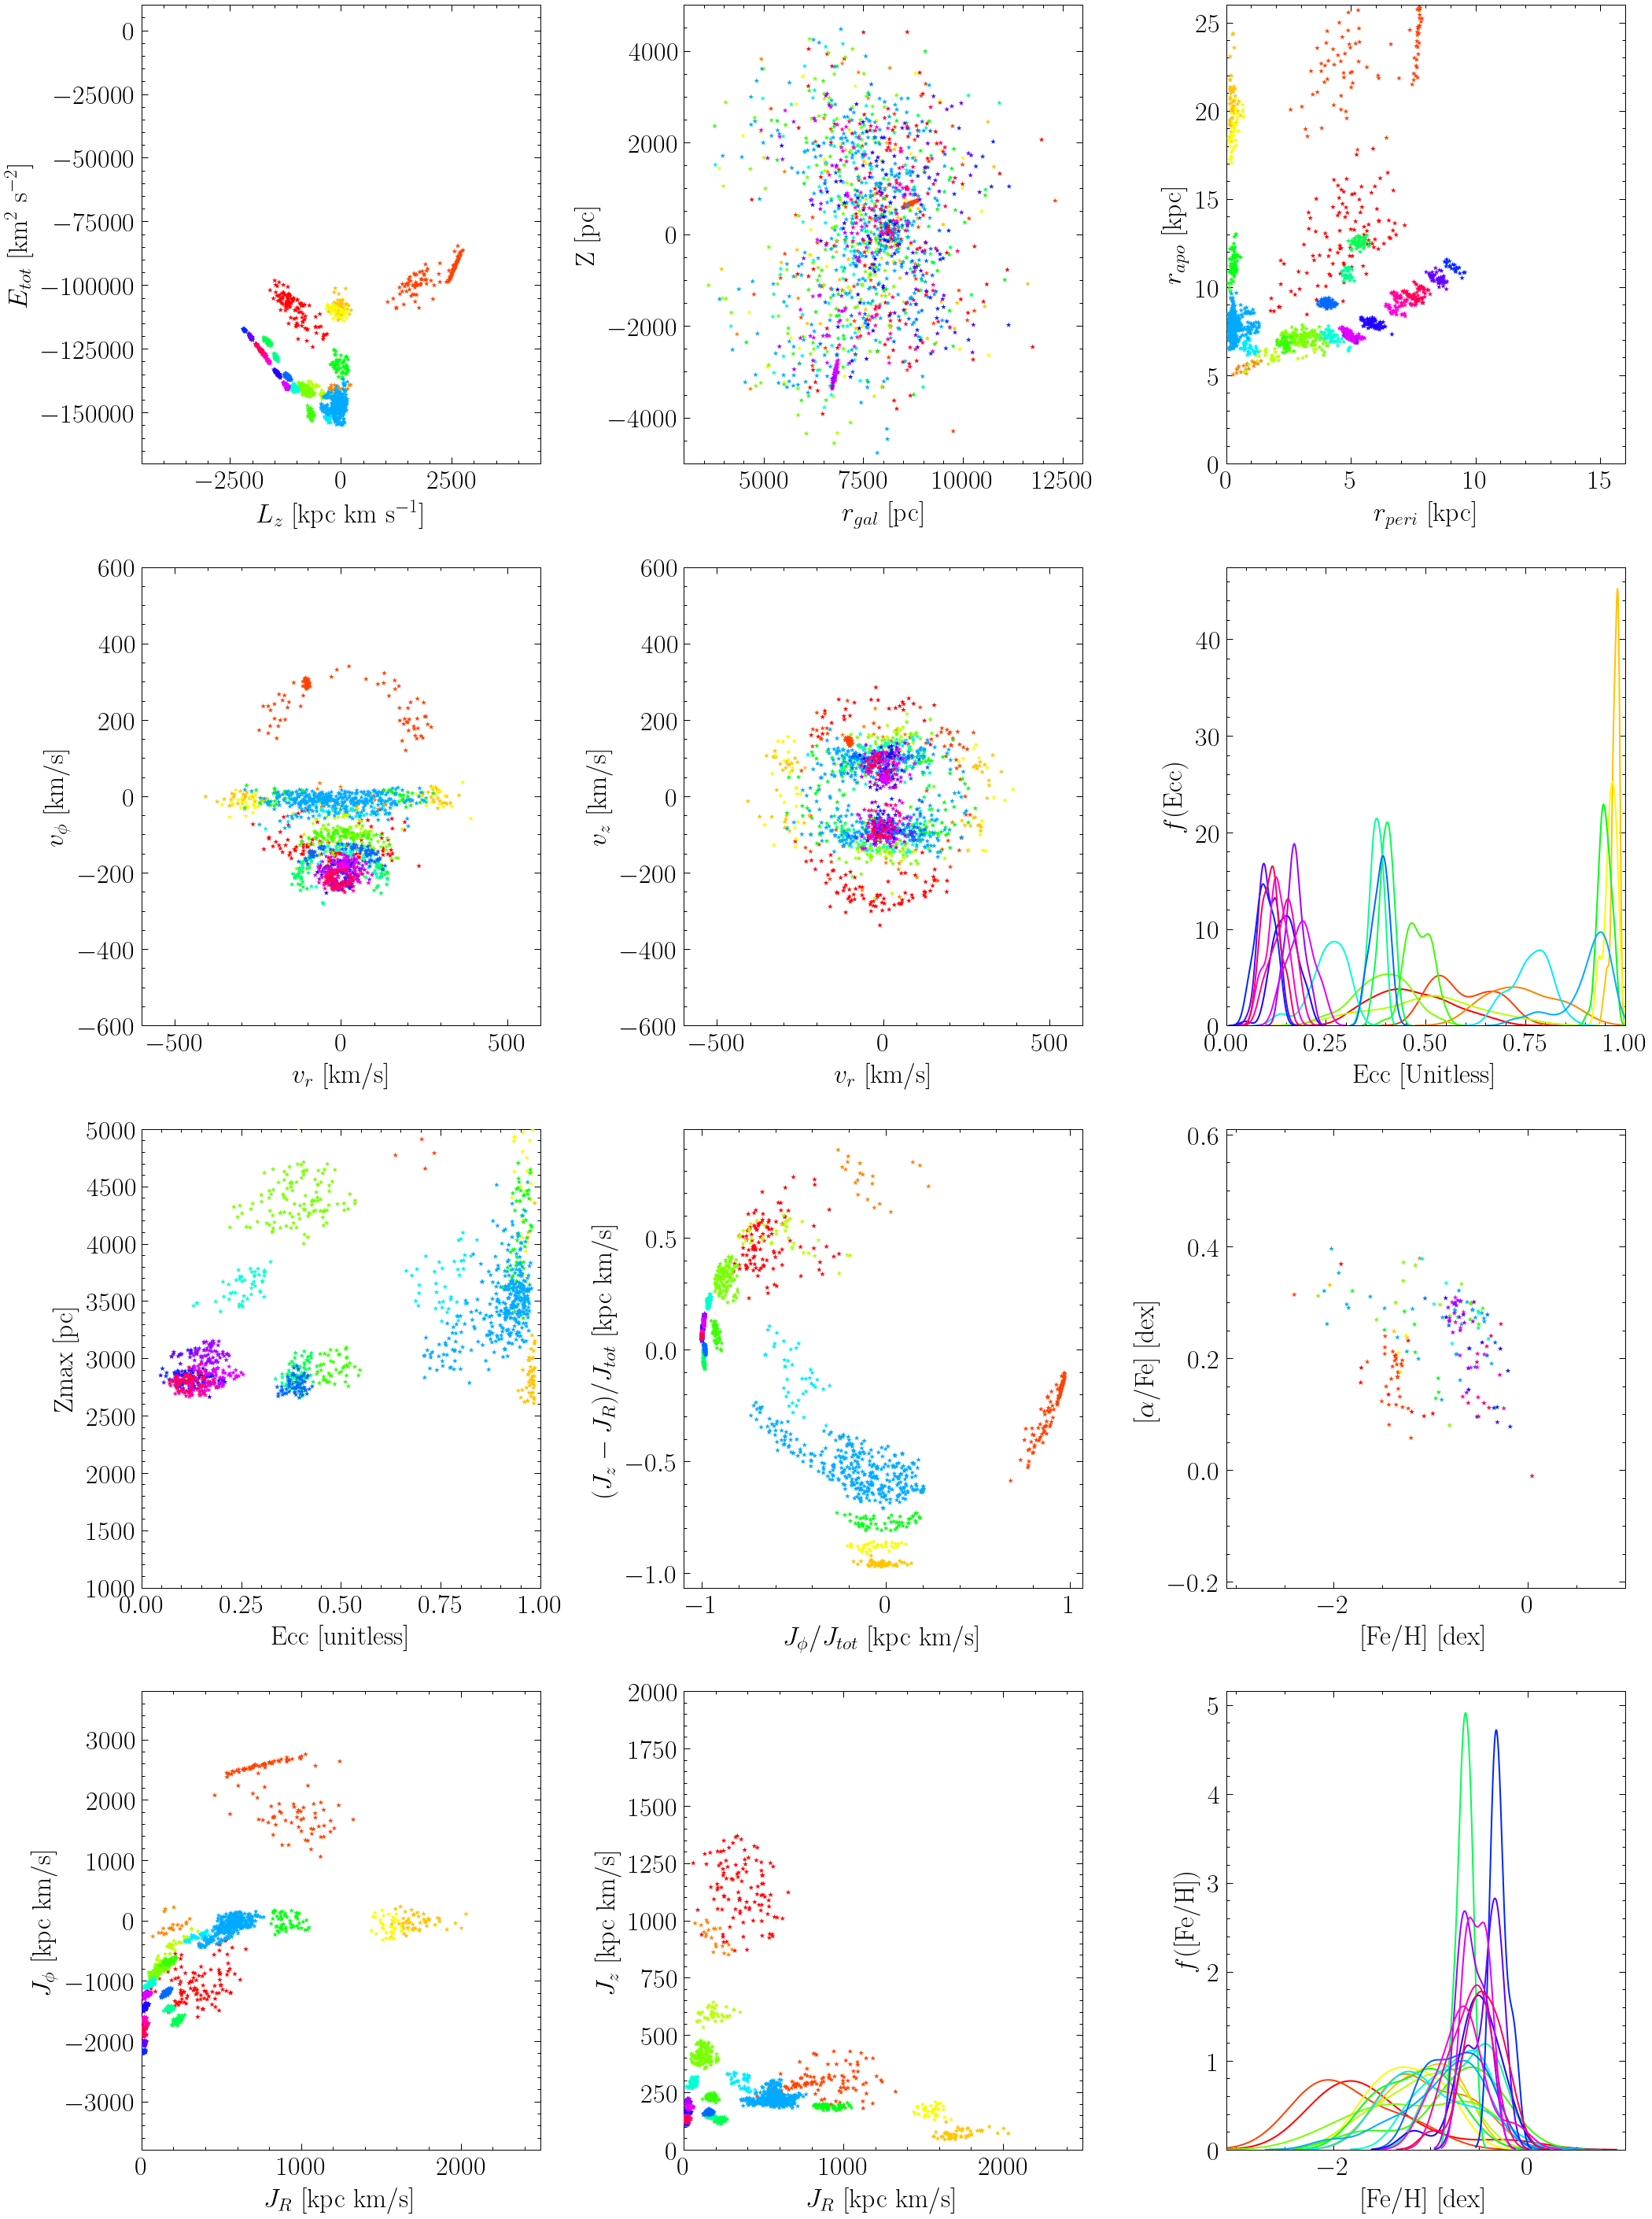

/var/folders/gf/j4j20wvx1d77qj5hx1gjrwf40000gn/T/ipykernel_93674/1316449873.py:197: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig(filename,layout='tight')


In [25]:
plot_summary_v3(df_vel_all,df_orb_all,ind_list=clust_all_ind,c_list=clust_all_col,
                title='',legends=['']*len(clust_all_ind),list_mask=False,ind_add_cut=[],ds=False,noise=False,
                filename='./'+clust_space[0]+'_'+clust_space[1]+'_plot_20_20_err_nocut/clustering_'+clust_space[0]+'_'+clust_space[1]+'_stacked_stars_in_clust_cut_'+clust_space[2]+'_hdbscan_min_samples_20_min_clustsize_20_leaf_summary_v3_kde_no_noise.pdf')

In [58]:
# Extract the metallicities for the two cluster
feh1 = df_vel_all.loc[clust1_ind,'m_h_mean'].values
feh2 = df_vel_all.loc[clust2_ind,'m_h_mean'].values

feh1_nonan = feh1[np.isnan(feh1) == False]
feh2_nonan = feh2[np.isnan(feh2) == False]

In [59]:
# Perform KS test on the two cluster
print(ks_2samp(feh1,feh2),ks_2samp(feh1_nonan,feh2_nonan))

Ks_2sampResult(statistic=0.041343669250646, pvalue=0.9999999649486467) Ks_2sampResult(statistic=0.5555555555555556, pvalue=0.4545454545454546)


In [63]:
ks_2samp(feh1,feh2)[1]

0.9999999649486467

In [60]:
print(feh1, feh1_nonan)
print(feh2, feh2_nonan)

[     nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan -0.8894       nan      nan -0.66503
 -0.34942      nan      nan      nan      nan      nan      nan      nan
 -0.32413      nan      nan      nan      nan -0.80307      nan -0.29712
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan -0.49487      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan -0.64271      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
 -0.5403 ] [-0.8894  -0.66503 -0.34942 -0.32413 -0.80307 -0.29712 -0.49487 -0.64271
 -0.5403 ]
[     nan      nan      nan      nan -0.62599      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan  

In [45]:
data1 = feh1
data2 = feh2

data1 = np.sort(data1)
data2 = np.sort(data2)
n1 = data1.shape[0]
n2 = data2.shape[0]
print(data1,data2)

data_all = np.concatenate([data1, data2])
print(data_all)
# using searchsorted solves equal data problem
cdf1 = np.searchsorted(data1, data_all, side='right') / n1
cdf2 = np.searchsorted(data2, data_all, side='right') / n2
print(cdf1,cdf2)
cddiffs = cdf1 - cdf2
print(cddiffs)

minS = np.clip(-np.min(cddiffs), 0, 1)
maxS = np.max(cddiffs)
# alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
# d = alt2Dvalue[alternative]
print(minS,maxS)

[-1.6494 -1.4697 -1.4697 -1.4678 -1.4657 -1.4555 -1.4251 -1.4032 -1.39
 -1.3862 -1.3674 -1.3545 -1.3532 -1.3525 -1.3456 -1.3381 -1.3381 -1.3338
 -1.3313 -1.3285 -1.3144 -1.2993 -1.2926 -1.2886 -1.2873 -1.2291 -1.1992
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan] [-1.3142 -1.2679     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan]
[-1.6494 -1.4697 -1.4697 -1.4678 -1.4657 -1.4555 -1.4251 -1.4032 -1.39
 -1.3862 -1.3674 -1.3545 -1.3532 -1.3525 -1.